# (WIP) Analysing trained networks

**Note**. This is a work in progress, unfinished notebook building on the [Starting Notebook](Starting-Notebook.ipynb). The current results are at the end, so scroll down to [Further Analyses](#Further-analyses) to see the new stuff.

Currently working on this: Dan Goodman

## Explanation

First of all, we reproduce the results of the starting notebook.

In [1]:
!pip install tqdm
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

from tqdm.notebook import trange, tqdm

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [2]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz   # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# # Plot a few just to show how it looks
# ipd, spikes = random_ipd_input_signal(8)
# spikes = spikes.cpu()
# plt.figure(figsize=(10, 4), dpi=100)
# for i in range(8):
#     plt.subplot(2, 4, i+1)
#     plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
#     plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
#     if i>=4:
#         plt.xlabel('Time (steps)')
#     if i%4==0:
#         plt.ylabel('Input neuron index')
# plt.tight_layout()

In [3]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


In [4]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

In [5]:
num_hidden = 30

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms, device=device, dtype=dtype):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec

In [6]:
# Parameters for training.
batch_size = 64
n_training_batches = 64
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/10 [00:00<?, ?batch/s]

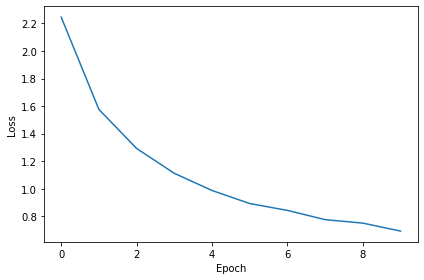

In [7]:
# Training parameters
nb_epochs = 10 # 50 still not enough to converge!
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
with trange(nb_epochs, unit="batch") as pbar:
    for e in pbar:
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, W1, W2)
            # Compute cross entropy loss
            m = torch.mean(output, 1)  # Mean across time dimension
            loss = loss_fn(log_softmax_fn(m), y_local)
            local_loss.append(loss.item())
            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        #print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        pbar.set_postfix(loss=np.mean(local_loss))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Chance accuracy level: 8.3%

Train classifier accuracy: 78.8%
Train absolute error: 5.1 deg

Test classifier accuracy: 48.7%
Test absolute error: 11.2 deg


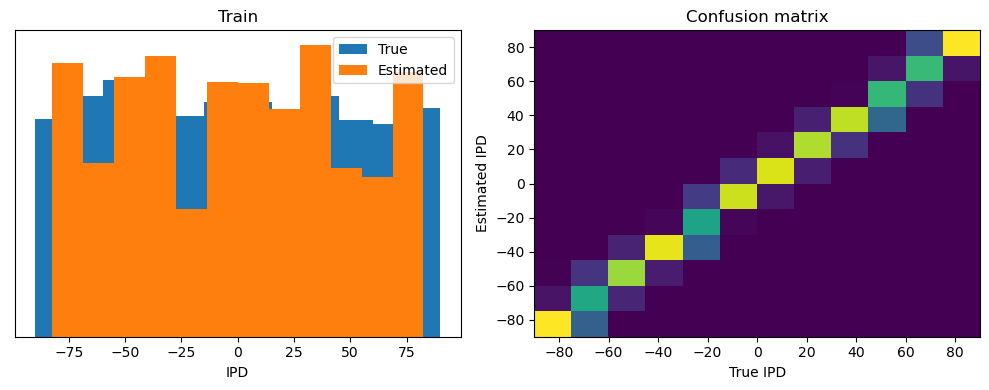

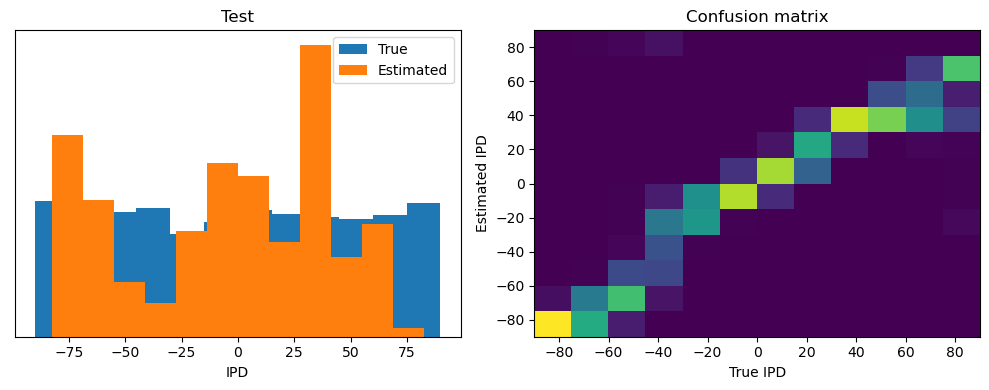

In [8]:
def analyse(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
    plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

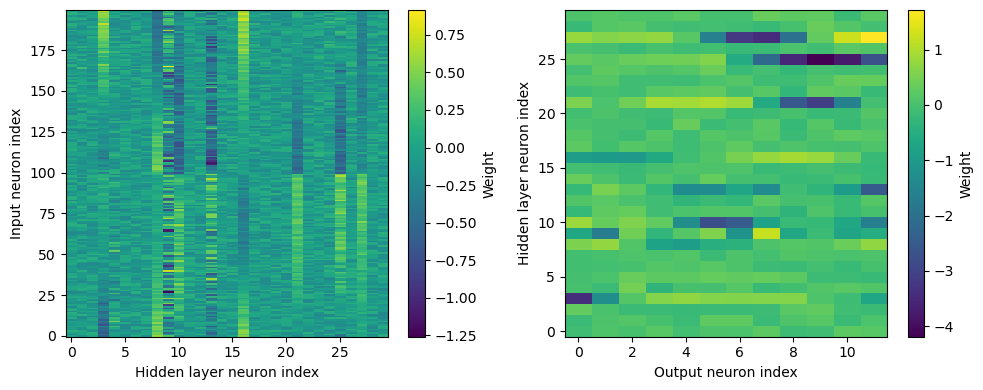

In [9]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

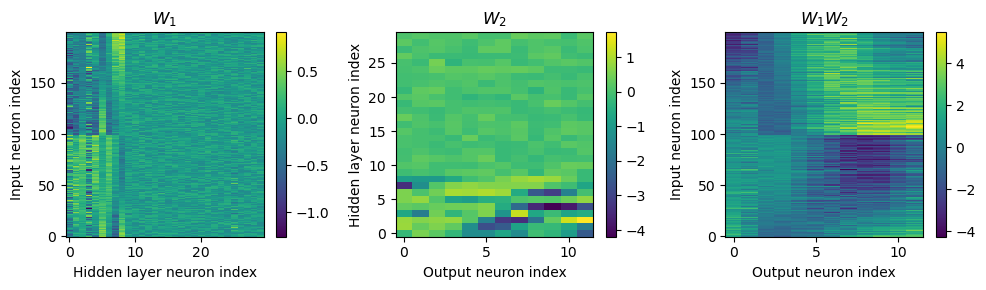

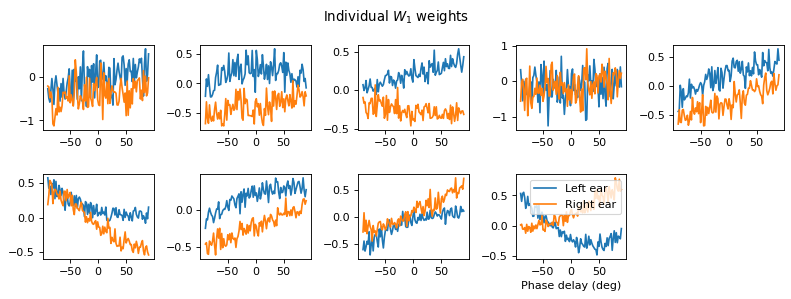

In [10]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

## Further analyses

What else can we do to try to understand what's going on?

Let's try computing tuning curves of the output class neurons.

In [31]:
# ipds_test shape (num_samples)
# spikes_test shape (num_samples, duration_steps, 2*anf_per_ear)
all_m = []
all_ipd = []
for x_local, y_local in data_generator(ipds_test, spikes_test):
    output = snn(x_local, W1, W2) # shape (batch_size, duration_steps, num_classes)
    m = torch.sum(output, 1) # shape (batch_size, num_classes)
#     m = log_softmax_fn(m)
    all_m.append(m)
    all_ipd.append(y_local)
cls_output = torch.cat(all_m, 0).detach().cpu().numpy() # shape (num_samples, num_classes)
ipds_ = torch.cat(all_ipd).detach().cpu().numpy()

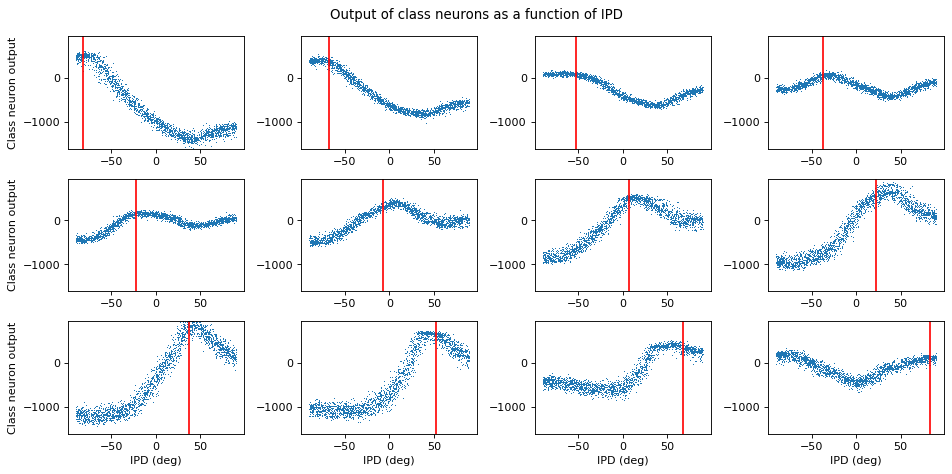

In [32]:
plt.figure(figsize=(12, 6), dpi=80)
for i in range(num_classes):
    plt.subplot(3, 4, i+1)
    plt.plot(ipds_*180/np.pi, cls_output[:, i], ',')
    plt.axvline(continuise(i)*180/np.pi, ls='-', c='r')
    if i//4==2:
        plt.xlabel('IPD (deg)')
    if i%4==0:
        plt.ylabel('Class neuron output')
    plt.ylim(cls_output.min(), cls_output.max())
plt.suptitle("Output of class neurons as a function of IPD")
plt.tight_layout()

Each subplot is one of the output class neurons. Each blue dot is (on the y-axis) its summed membrane potential (used to make the decision) in response to a particular IPD (x-axis). The red line is the estimated IPD if that neuron has the highest value compared to the other neurons (in other words, its "best" IPD).

That's pretty cool. We can see that these tuning curves look not unlike the tuning curves of real neurons. But, this still doesn't tell us HOW these neurons are doing what they're doing.

## Things to do

* Compute tuning curves of hidden layer
* Compute how hidden layer neurons are working (look at some examples in detail)
* Are they using coincidence detection or using some other trick?
* What strategy are they using for weighting different values?